# Tarea 2 ML

Ignacio Loayza 201273604-8  
Camilo Perez 201273533-5


> Iniciamos el estudio importando las librerías necesarias y seteando la semilla.

In [126]:
#encoding:UTF-8

# Uno de nosotros usa python 2 y el otro python 3
from __future__ import print_function, unicode_literals

# estadistica
import pandas as pd

#pyplot
import matplotlib.pyplot as plt
%matplotlib inline

# numpy
import numpy as np

#Utilizaremos la semilla = "Ñanculef es mi pastor, nada me ha de  faltar"
seed = "Ñanculef es mi pastor, nada me ha de faltar"
seed = hash(seed)%2^32

## Utils
from sklearn.utils import check_random_state
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from ipywidgets import interactive
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interactive
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import train_test_split
from pandas_ml import ConfusionMatrix
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from collections import Counter
import re

>Definimos además un par de funciones útiles que servirán más adelante

In [3]:
"""
visualize_border puede hacer dos cosas, si no se le pasa un modelo permite
    visualizar la distirbución de los datos. Si se le pasa entrega el gráfico de
    distribucion de los datos junto con la frontera de clasificación del modelo.
"""
def visualize_border(x, y, title = "", model = None):
        fig = plt.figure(figsize=(12,6))
        plt.scatter(x[:,0], x[:,1], s = 50, c=y, cmap=plt.cm.winter)
        h = .02 #step size?
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max()+1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        if model is not None:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, cmap = plt.cm.Paired)
        
        plt.title(title)
        plt.show()

        
"""
visualize_border_interactive grafica la frontera de decisión utilizando visualize_border,
adicionando la opción de ingresar un parámetro
requisito: variables X e y con los datos fuera de la función
"""
def visualize_border_interactive(param, learner, **kwargs):
    model = train_model(X_visualize, y_visualize, param, model = learner, **kwargs)
    visualize_border(X_visualize, y_visualize, model = model)
    y_pred = model.predict(X_visualize)
    y_true = y_visualize
    print("For the training data:")
    print("\tModel precission: ", accuracy_score(y_true,y_pred))
    print("\tMisclassification error: %f"%(1-accuracy_score(y_true,y_pred)))

    try:
        y_pred = model.predict(X_test_visualize)
        y_true = y_test_visualize
        print("For the test data:")
        print("\tModel precission: : ", accuracy_score(y_true,y_pred))
        print("\tMisclassification error: %f"%(1-accuracy_score(y_true,y_pred)))
    except NameError: # no habia conjuntos de validacion definidos
        pass
    except ValueError: # quedo un conjunto de pruebas de otro modelo en memoria
        pass
    
def train_model(X, y, param, model = "LR", **kwargs):
    if(model == "LR"):
        model = LR()
        try:
            penalty = kwargs["penalty"]
        except KeyError:
            penalty = "l1"
        model.set_params(C = param, penalty = penalty)

    elif(model == "SVM"):
        model = SVM()
        try:
            kernel = kwargs["krnl"]
        except KeyError:
            kernel = "linear"
        model.set_params(C = param, kernel = kernel)

    elif(model == 'KNN'):
        model = KNeighborsClassifier()
        try:
            neighbors = kwargs["neighbors"]
        except KeyError:
            neighbors = 5
        model.set_params(n_neighbors = neighbors)
        
    model.fit(X,y)
    return model

## I ) Tipos de Fronteras de Clasificación

>Ahora generaremos el dataset a utilizar en la parte 1

In [4]:
n_samples = 500
mean = (0,-4)
C = np.array([[0.3,0.1],[0.1,1.5]])
datos1 = np.random.multivariate_normal(mean,C,n_samples)
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x, outer_circ_y)).T

generator = check_random_state(seed)
datos2 += generator.normal(scale=0.3,size = datos2.shape)

> ### Análisis exploratorio de Datos

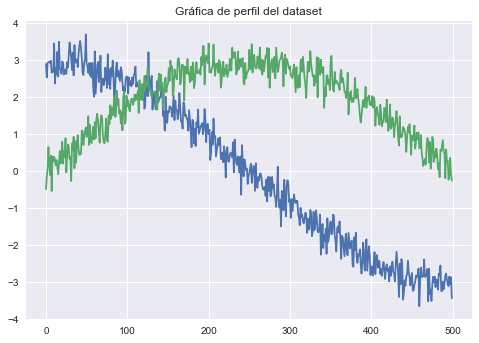

In [5]:
plt.plot(datos2)
plt.title("Gráfica de perfil del dataset")
plt.show()

> a) Construimos el dataset común con los dos conjuntos generados, posteriormente realizamos el shift de algunos valores de un conjunto al otro, con el fin de hacer menos trivial el ejercicio.

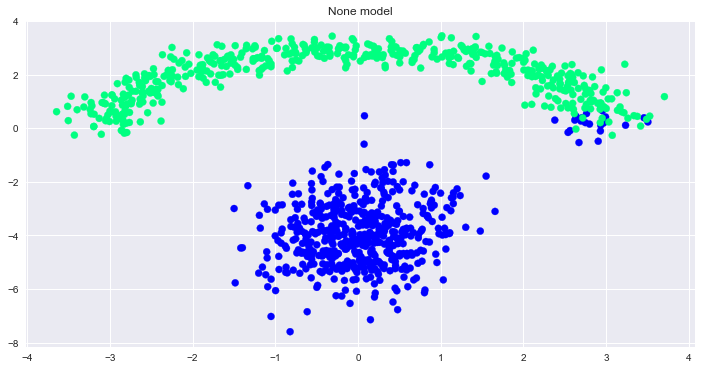

In [6]:
X = np.concatenate((datos1,datos2), axis = 0)
n = 20 #ruido?
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis = 0)
visualize_border(X,y,"None model")

> b) Entrenamos LDA y visualizamos la frontera de decisión:

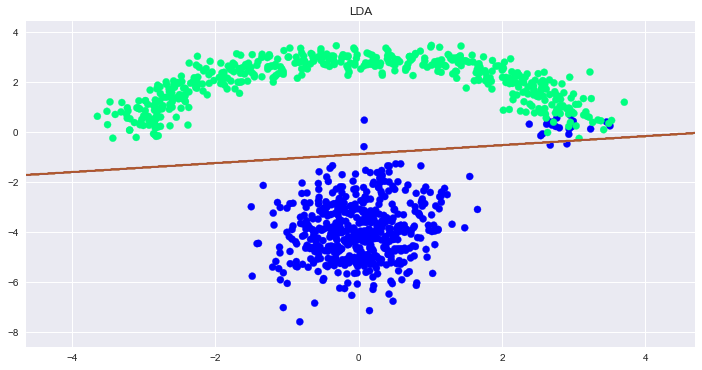

In [7]:
lda_model = LDA()
lda_model.fit(X,y)
visualize_border(X,y,title = "LDA",model = lda_model)

Observamos que LDA encuentra una frontera aceptable, teniendo en cuenta ciertos fallos de clasificación (cercanos al punto (0,-2)) que parecen ser inevitables debido a la naturaleza de los datos

> c) Entrenamos ahora utilizando QDA

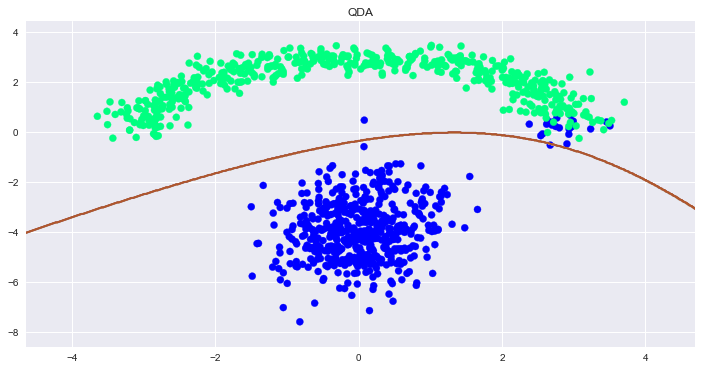

In [8]:
qda_model = QDA()
qda_model.fit(X,y)
visualize_border(X,y, title = "QDA", model = qda_model)

> c) La frontera que implementa QDA soluciona el error de clasificación que se presentaba en los puntos cercanos a (0,-2) en LDA, sin embargo, aún se hace presente el error de clasificación de los valores afectados por el ruido en el cuadrante (2:4,0:2).  
> Podemos explicar el rendimiento de QDA versus LDA recordando los discriminadores probabilísticos implementados en cada método:
>> * LDA para dos clases: Implementa un discriminador probabilístico condicional, asumiendo que las funciones de probabilidad marginal son distribuidas bajo una normal con media y covarianza $(\mu_0,\sum_0)$ y $(\mu_1,\sum_1)$ para las clases. La solución al problema de clasificación mediante LDA entonces, se basa en la evaluación de la función de verosimilitud y aplicando un umbral de decisión.
>> * QDA: Similar a LDA, este clasificador asume normalidad, sin embargo, QDA no asume que la covarianza de cada clase es igual (a diferencia de LDA). De igual forma que en LDA, en QDA la decisión de clasificación se basa en el análisis de la tasa de verosimilitud. En QDA se asume una solución cuadrática en las mediciones, es decir:
$$x^TAx + b^Tx + C$$

> d) Comparamos el rendimiento de QDA y LDA mediante el error de clasificación.

In [9]:
y_pred_qda = qda_model.predict(X)
y_true = y

y_pred_lda = lda_model.predict(X)

print("Misclassification loss for QDA: %f"%(1-accuracy_score(y_true, y_pred_qda)))
print("Misclassification loss for LDA: %f"%(1-accuracy_score(y_true, y_pred_lda)))

Misclassification loss for QDA: 0.020000
Misclassification loss for LDA: 0.020000


> LDA presenta mayor error que QDA, lo que se esperaba que sucediese, pues LDA no logra evitar el error de clasificación en el sector cercano a (0,-2) mencionado anteriormente, QDA si. Por otro lado el error de clasificación obtenido para QDA tiene sentido pues los datos incorrectamente clasificados corresponden a los datos a los que se les agrego ruido (20 datos), correspondiendo al 2% de los datos generados, esto se cumple de forma análoga para LDA si tomamos en cuenta los datos cercanos al punto conflictivo mencionado.

> e), f) y g) Construimos un gráfico interactivo donde modificamos el valor de penalización para la norma l2

In [10]:
# definimos el rango de valores de penalización
p_min = 0.01
p_max = 10.0
learners = {'SVM': 'SVM', 'Regresión Logistica': 'LR'}
kernels = {'lineal':'linear', 'rbf':'rbf', 'polinomial':'poly', 'sigmoid':'sigmoid'}
X_visualize = X
y_visualize = y
interactive(visualize_border_interactive, param = (p_min,p_max), learner = learners, krnl = kernels)

> Podemos observar que la frontera de clasificación tiene poca variación en su pendiente frente a diferentes valores del parámetro de regularización. El mejor resultado obtenido por inspección se registra para un clasificador basando en SVM, con kernel del tipo 'rbf' y parámetro de regularización de 1.71, obteniendose 0.009 error de clasificación.

> h) Construimos ahora un clasificador del tipo Decision Tree.<br>
Antes de comenzar a construir el modelo vale la pena comentar un poco las características del modelo en cuestión, debido a que es un método no paramétrico, tiene tendencia al sobreajuste, en particular se da el caso de que para una alta dimensionalidad (en comparación con el tamaño muestral), los árboles de decisión se sobreajustan. Es por lo anterior que antes de construir el modelo, utilizaremos PCA para reducir dimensionalidad.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 64)
tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy',
                        max_depth = 3)
tree_clf = tree_clf.fit(x_train,y_train)

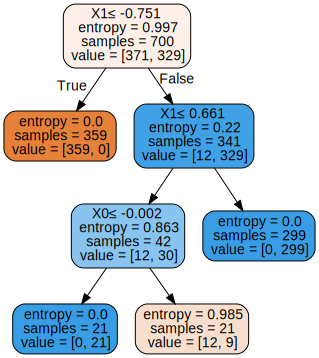

In [12]:
# OBS: Ejecutar esta celda requiere tener instalado graphviz

import graphviz
dot_data = tree.export_graphviz(tree_clf, out_file = None)
graph = graphviz.Source(dot_data)
graph.render("Wave")
dot_data = tree.export_graphviz(tree_clf, out_file=None,   
                         filled=True, rounded=True,  
                         special_characters=True,)  
graph = graphviz.Source(dot_data)
graph

In [13]:
print("Número de clases detectadas: ",tree_clf.n_classes_)
print("Número de atributos: ",tree_clf.n_features_)
print("Precisión del modelo: ",tree_clf.score(x_test,y_test).round(3))


y_pred = tree_clf.predict(x_test)
cm = np.matrix(ConfusionMatrix(y_test,y_pred))
cm

Número de clases detectadas:  2
Número de atributos:  2
Precisión del modelo:  0.98


matrix([[ Predicted  0.0  1.0  __all__
 Actual                      
 0.0        149    0      149
 1.0          6  145      151
 __all__    155  145      300]], dtype=object)

i) k-NN

In [14]:
interactive(visualize_border_interactive, param = (p_min,p_max), learner = 'KNN', neighbors = (1,9))


## Análisis de datos de audio

In [15]:
from scipy.io import wavfile
def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name
SAMPLE_RATE = 44100
def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

In [16]:
df = pd.read_csv('./heartbeat-sounds/set_a.csv')
set_df = set(df['label'])
set_array = list(set_df)
len(set_array)

5

>b) Transformamos los archivos *.wav* a secuencias de tiempo

In [17]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux
new_df = pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='./heartbeat-sounds/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))

>c) Al parecer los datos se encuentran incorrectamente etiquetados, así es espeficado por Pter Grenholm, quien con su background medico analizó los datos y se dió cuenta de la inconsistencia (https://www.kaggle.com/toregil/new-labels-for-set-a).

In [18]:
new_labels=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,1,1,
 1,1,1,1,1,2,1,1,1,2,2,2,1,1,2,1,2,2,1,2,2,2,2,2,2,
 2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,
 1,2,1,1,1,1,1,2,1,1,1,1,1,1,1,2,2,1,1,1,1,1,2,1,0,
 2,2,1,1,1,1,1,0,1,0,1,1,1,2,1,0,1,1,1,1,1,2,0,0,0,
 0,0,0,0,1,0,0,0,0,0,0,1,0,2,1,2,2,2,2,2,2,2,2,2,2, 2]
labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

In [19]:
new_df.head()

,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,artifact
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,artifact
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,artifact
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,artifact
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,artifact


>Este proceso es necesario y útil en la investigación que estamos realizando porque tener datos mal etiquetados significa entrenar nuestros modelos con valores ruidosos, disminuyendo el poder predictivo del mismo y haciendolo propenso a fallar frente a nuevos datos. Es importante también hacer notar lo valioso de tener una opinión de un agente experto en el dominio del dataset, que nos permita corregir y verificar información.

>d) Ahora, codificamos las clases como valores numéricos, este paso es vital para poder ejecutar modelos de aprendizaje sobre los datos, de no hacer las transformaciones correspondientes podriamos estar alimentando los modelos con basura.

In [20]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

>e) Se desordenan los datos y se convierten en el formato a trabajar, de forma que cada dato sea una secuencia de amplitudes, y que eso sea lo único que vea el algoritmo.

In [21]:
new_df = new_df.sample(frac=1,random_state=44)
X_data = np.stack(new_df['time_series'].values, axis=0)
y_data = new_df.target.values
X_data.shape

(176, 396900)

>Existe un problema al observar la dimensión de esta matriz. Las columnas representan atributos desde el punto de vista de los algoritmos clasificadores. Por lo tanto, con 396900 atributos, los algoritmos se enfrentarán a un problema muy costoso de resolver, afectado enormemente por la "maldición de la dimensionalidad". Por lo tanto, se requiere algún tipo de preprocesamiento para poder resolver el problema y encontrar un modelo antes de que salgamos de la carrera.

>f) Primero, se convierten tiempos a frecuencias mediante una transformada de Fourier discreta.

In [22]:
X_fourier = np.abs(np.fft.fft(X_data))

>g) Luego, se aplica una técnica de muestreo de señales de audio.

In [23]:
from scipy import signal
X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)
X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

>Con esto hemos logrado reducir las dimensiones del problema de 396900 a 100000, que es bastante más manejable. Podemos asegurar que el muestreo es representativo dada la naturaleza periódica de las funciones resultantes de las transformadas de Fourier.

>h) Ahora, con los datos listos para empezar a ser trabajados, separaremos los conjuntos de entrenamiento y de pruebas.

In [24]:
# en este punto se tiene:
# X_data, y_data: datos originales
# X_resampled: remuestreo de la data X original

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_data, test_size=0.25, random_state=42)
print("Clases en conjunto de entrenamiento:", len(set(y_train)))
print("Clases en conjunto de pruebas:", len(set(y_test)))
print("Entradas en conjunto de entrenamiento:", X_train.shape[0])
print("Entradas en conjunto de pruebas:", X_test.shape[0])

# Ahora además aparecen los conjuntos de entrenamiento y pruebas
# X_train, y_train,
# X_test, y_test

Clases en conjunto de entrenamiento: 3
Clases en conjunto de pruebas: 3
Entradas en conjunto de entrenamiento: 132
Entradas en conjunto de pruebas: 44


>En retrospectiva, tiene mucho sentido que la cantidad de clases no varíe al separar los datos en conjuntos de entrenamiento y pruebas (recordar que se cambiaron las etiquetas por sugerencia del experto en el área). Y que se separen en cantidades que siguen la tasa que se le entregó a `train_test_split`.

>i) Ahora procedemos a estandarizar los datos, restando la media y dividiendo por la desviación estándar

In [25]:
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

>j) Realizamos un análisis de las componentes principales con el fin de reducir dimensionalidad, utilizaremos un kernel sinusoidal debido a la naturaleza de los datos, los cuales fueron tratados con una transformada de Fourier.

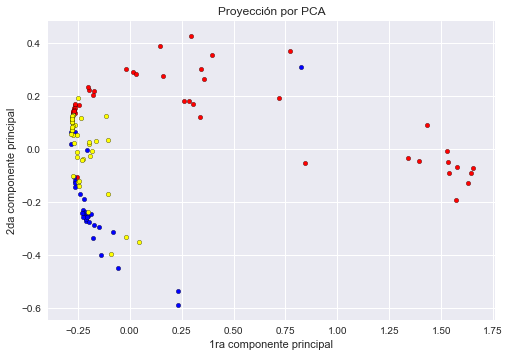

In [26]:
d = 2
pca_model = KPCA(n_components=d, kernel = 'cosine')
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

class0 = np.array([x[0] for x in zip(X_pca_train, y_train) if x[1] == 0])
class1 = np.array([x[0] for x in zip(X_pca_train, y_train) if x[1] == 1])
class2 = np.array([x[0] for x in zip(X_pca_train, y_train) if x[1] == 2])

plt.scatter(class0[:,0], class0[:,1], c="red",s=20, edgecolor='k')
plt.scatter(class1[:,0], class1[:,1], c="blue",s=20, edgecolor='k')
plt.scatter(class2[:,0], class2[:,1], c="yellow",s=20, edgecolor='k')


plt.title("Proyección por PCA")
plt.xlabel("1ra componente principal")
plt.ylabel("2da componente principal")
plt.show()

>Se colorearon los datos de forma que se muestre la clase original a la que pertenecen. Si cambiamos el kernel, los datos quedan notoriamente mezclados.

>k) Ahora se construirán un modelo de regresión logística y una máquina de soporte vectorial variando el parámetro de regularización.

In [27]:
Cs = [0.1,1,10,100,1000]
penalty = {'l1':'l1','l2':'l2'}
learner = {"SVM":"SVM", "Regresión logística":"LR"}
X_visualize = X_pca_train
y_visualize = y_train
X_test_visualize = X_pca_test
y_test_visualize = y_test
interactive(visualize_border_interactive,
            param = Cs, penalty = penalty, learner = learner)

>Se observa que la regresión logística tiende a preferir el cortar el espacio en tres con tres rectas con un punto en común. Se obtiene un error de clasificación para el conjunto de entrenamiento del 25% para valores muy altos del parámetro de regularización con este enfoque. Mientras tanto, la SVM decide cortar el espacio en 3 con dos líneas, lo cual ofrece un error del 17% sobre el conjunto de entrenamiento. La SVM también se comporta consistentemente mejor al realizar pruebas sobre el conjunto de datos que se designó previamente como conjunto de pruebas.

> l) Ahora se procederá a realizar lo mismo con un árbol de clasificación.

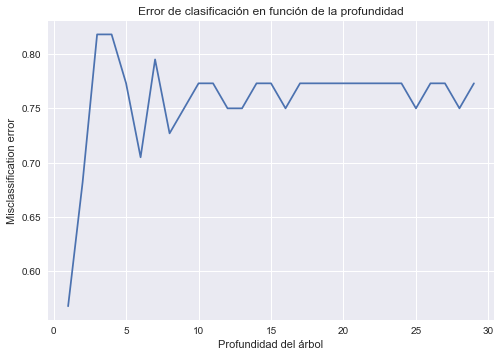

In [28]:
Depths = range(1,30)
errors = list()
for depth in Depths:
    tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = depth)
    tree_clf = tree_clf.fit(X_visualize,y_visualize)
    errors.append(tree_clf.score(X_test_visualize,y_test_visualize).round(3))
plt.xlabel("Profundidad del árbol")
plt.ylabel("Misclassification error")
plt.title("Error de clasificación en función de la profundidad")
plt.plot(Depths, errors)
plt.show()

> Observamos una aparente convergencia en el errror al aumentar la profundidad máxima permitida, desde el una profundidad máxima de 10, se obtienen errores de clasificación dentro del intervalo [0.70, 0.80]. Los árboles de clasificación tienden al sobreajuste, este comportamiento puede que responda a esta naturaleza.

m) Pruebas con diverso número de componentes para el análisis de las componentes principales

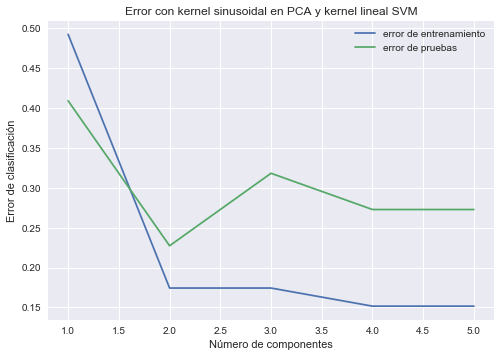

In [29]:
def multiple_components_pca(n_comp):
    components = range(1, n_comp+1)
    errors_train = []
    errors_test = []
    for c in components:
        kpca_model = KPCA(n_components = c, kernel = 'cosine')
        kpca_model.fit(X_train)
        
        X_kpca_train = kpca_model.transform(X_train)
        X_kpca_test = kpca_model.transform(X_test)
        
        my_svm = SVM()
        my_svm.set_params(kernel = "linear", C = 100)
        my_svm.fit(X_kpca_train, y_train)
        
        y_pred = my_svm.predict(X_kpca_train)
        y_true = y_train
        score = accuracy_score(y_true, y_pred)
        errors_train.append(1-score)
    
        y_pred = my_svm.predict(X_kpca_test)
        y_true = y_test
        score = accuracy_score(y_true, y_pred)
        errors_test.append(1-score)        
        
    plt.plot(components,errors_train, label = "error de entrenamiento")
    plt.plot(components,errors_test, label = "error de pruebas")
    plt.xlabel("Número de componentes")
    plt.ylabel("Error de clasificación")
    plt.title("Error con kernel sinusoidal en PCA y kernel lineal SVM")
    plt.legend()
    plt.show()


multiple_components_pca(5)

n) Probaremos ahora con análisis de discriminante lineal (LDA)

/Users/Ignacio/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


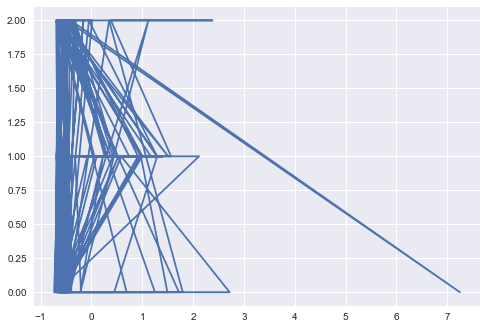

In [30]:
model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_pca_train = model_lda.transform(X_train)
X_pca_test = model_lda.transform(X_test)

# mostrar los primeros 10 atributos para que esto no colapse
plt.plot(X_train[:,10],y_train)
plt.show()

>Se puede apreciar el mensaje de warning `Variables are collinear`. Esto se produce porque las variables son colineales. Procederemos a hacer un análisis exploratorio con respecto a los atributos y a la variable target con el fin de encontrar las colinealidades.

## 3. Análisis de sentimientos
En esta sección se realizará un análisis de sentimientos sobre un dataset que contiene *tweets*, el dataset es ofrecido por CrowndFlower. Nuestro objetivo será asociar cada tweet a una emoción.

In [55]:
#carga del dataset
emotions = pd.read_csv('./emotions/text_emotion.csv')

### a) Breve análisis exploratorio y descriptivo del dataset:

In [180]:
print("Cantidad de registros:", len(emotions))
emotions.head()

Cantidad de registros: 40000


,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


Tenemos cuatro atributos, en la columna *content* podemos apreciar ciertos carácteres especiales como '@', el valor de la colimna tweets_id debiese ser único y nose servirá para diferenciar cada texto. La cantidad de registros del dataset es cuarenta mil.

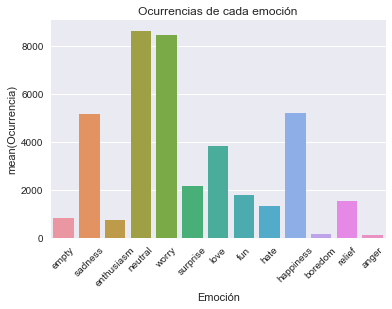

In [125]:
c = Counter(emotions.sentiment)
emotion_types = list(c.keys())
emotion_count = list(c.values())

emotion_summary = pd.DataFrame()
emotion_summary['Emoción'] = emotion_types
emotion_summary['Ocurrencia'] = emotion_count

plt.title('Ocurrencias de cada emoción')
plt.xlabel('Emoción')
sn.barplot( x = 'Emoción', y = 'Ocurrencia',data = emotion_summary)
plt.xticks(rotation = 45);

Existen trece clases de emociones comprendidas por los *tweets*, notar que las emociones son conjuntos disjuntos, no existe un *tweet* categorizado como dos o más emociones.

In [119]:
#Hacemos un dataset con las emociones
emotion_summary.sort_values(by = 'Ocurrencia', ascending = False)

,Emoción,Ocurrencia
3,neutral,8638
4,worry,8459
9,happiness,5209
1,sadness,5165
6,love,3842
5,surprise,2187
7,fun,1776
11,relief,1526
8,hate,1323
0,empty,827


La moda de las emociones es la *neutral*, seguida por *worry* y *happiness*. Es interesante notar que *sadness* y *happiness*  difieren en tan solo cuarenta y cuatro ocurrencias<br>
Exploremos ahora la variable *Content*, esta variable contiene el texto del *tweet* el cual tuvo que ser catalogado, como se mencionó anteriormente, se observan ciertos carácteres especiales. Sobre lo último puede ser interesante rescatar los hashtags ya que estos strings parecen nacer de sintetizaciones naturales de la persona con respecto a su texto, además encontrar ciertos patrones en el uso y frecuencia de ciertos hashtags puede revelarnos cierta información con respecto a la naturaleza del dataset.<br>
Nos serviremos de expresiones regulares para recuperar los hashtags en los textos y ver si hay repeticiones en los mismos.

In [165]:
tweets_content = emotions.content #Extraemos la columna correspondiente al texto a analizar
hashtags = [] # Quiero agradecer a Camilo por haber enseñado esta forma de declarar listas en python.

#Ahora iteramos sobre cada uno de los tweets y aplicamos un filtro por expresion regular
for text in tweets_content:
    if re.findall(r"#(\w+)",text) is not None:
        hashtags.append(re.findall(r"#(\w+)",text))
hashtags = list(filter(None,hashtags)) #Limpiamos de la lista aquellos string vacios (tweets donde no hubo hashtags)

hashtags = [item for sublist in hashtags for item in sublist] #voila

#Veamos la cantidad de hashtags distintos que hay
c_hashtags = Counter(hashtags)
hashtags_classes = c_hashtags.keys()
hashtags_freq = c_hashtags.values()

df_hashtags = pd.DataFrame()
df_hashtags['Hashtag'] = hashtags_classes
df_hashtags['Frecuencies'] = hashtags_freq
df_hashtags = df_hashtags.sort_values(by='Frecuencies', ascending=False)
print("Número de hashtags distintos: ",len(df_hashtags))
print("\n13 hashtags con más cantidad de ocurrencias:")
df_hashtags.head(13)

Número de hashtags distintos:  575

13 hashtags con más cantidad de ocurrencias


,Hashtag,Frecuencies
2,fb,43
464,frenchieb,35
76,followfriday,29
41,bgt,17
107,twpp,16
343,starwarsday,13
33,2,11
188,BGT,11
19,1,11
467,SanctuarySunday,9


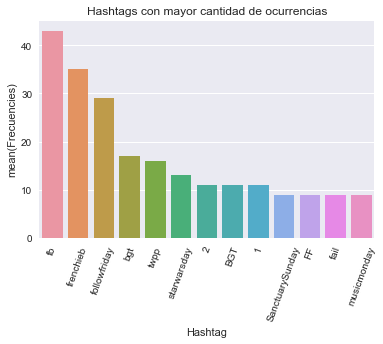

In [178]:
top13_hashtags = df_hashtags.head(13);
plt.xticks(rotation = 70);
plt.title('Hashtags con mayor cantidad de ocurrencias');
sn.barplot(x = 'Hashtag', y = 'Frecuencies', data = top13_hashtags);

El hashtag *#fb* (Facebook) claramente domina con respecto a los demás y es razonable tomando en cuenta la popularidad de la plataforma, el siguiente *hashtag* más popular corresponde a *#frenchieb* el cual está asociado a la raza de perro Bulldog Francés (*French Bulldog*), esta popularidad es un descubrimiento interesante. Finalmente, el tercer hashtag más popular corresponde a *#followfriday* ("Viernes de seguir"), es un hashtag que se institucionalizó como costumbre en *Tweeter*, la idea es que cada viernes se coloque un mensaje en tweeter con este hashtag seguido de algún usuario de la misma plataforma a la que el autor del *tweet* recomiende seguir, tiene sentido que este hashtag se encuentre dentro de los más populares al tener una funcionalidad compartida por muchos usuarios de la plataforma, finalmente, mencionar que otra abreviación válida para este último hashtag es *FF* el cuál también se encuentra dentro de los más mencionados.

### b) Construcción de los conjuntos de prueba y entrenamiento

In [ ]:
#Mejor utilizamos la funcionalidad de sklearn para este proceso
train_test_split(emotions, test_size = .2)